In [1]:
import os
os.chdir("../")
%pwd

'd:\\Final-Year-Project\\Credit-Card-Fraud-Detection-Using-GNN'

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15692\2669400142.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(graph_data_path)


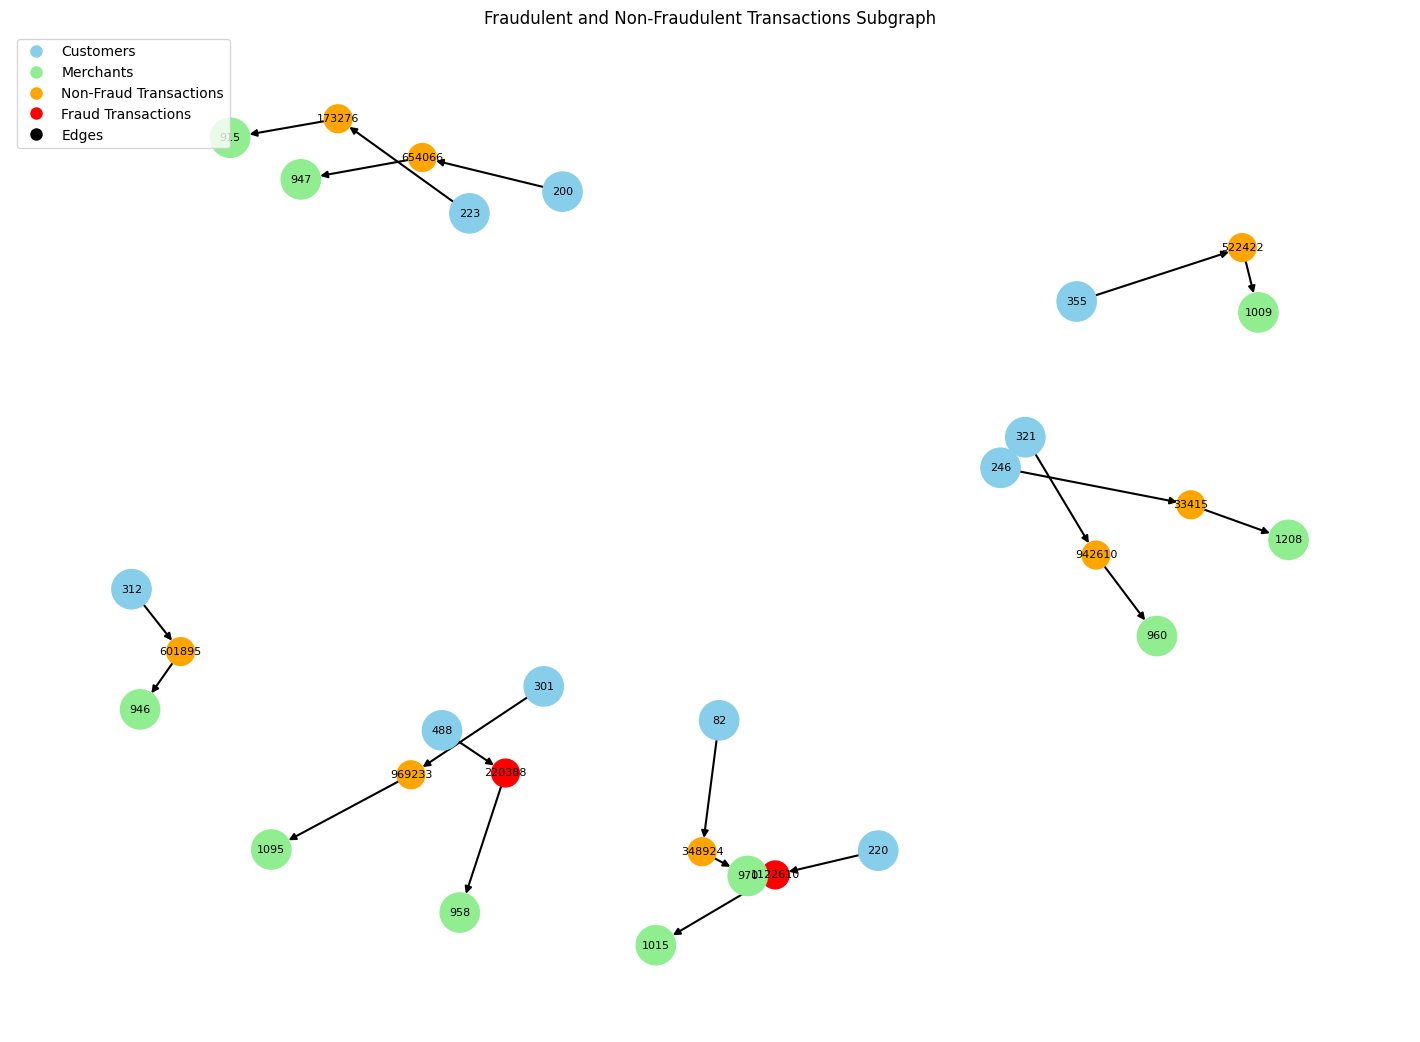

In [7]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import logging

def visualize_fraud_subgraph(graph_data_path, transformed_data_path, num_transactions, fraud_ratio):
    """
    Visualizes a subgraph containing customers, merchants, and transactions,
    ensuring ~10% fraudulent transactions.
    """
    try:
        # Load graph data
        data = torch.load(graph_data_path)
        df = pd.read_csv(transformed_data_path)
        
        # Identify fraud and non-fraud transactions
        fraud_transactions = df[df['is_fraud'] == 1]['transaction_node'].tolist()
        non_fraud_transactions = df[df['is_fraud'] == 0]['transaction_node'].tolist()
        
        # Determine how many fraud transactions to include
        num_fraud = min(len(fraud_transactions), int(num_transactions * fraud_ratio))
        num_non_fraud = min(len(non_fraud_transactions), num_transactions - num_fraud)
        
        # Select transactions
        selected_fraud = random.sample(fraud_transactions, num_fraud)
        selected_non_fraud = random.sample(non_fraud_transactions, num_non_fraud)
        selected_transactions = set(selected_fraud + selected_non_fraud)
        
        # Extract relevant edges
        edges = []
        customer_transacts_transaction = data[('customer', 'transacts', 'transaction')].edge_index.numpy()
        transaction_occurs_at_merchant = data[('transaction', 'occurs_at', 'merchant')].edge_index.numpy()
        
        # Filter edges that involve selected transactions
        for src, dst in zip(*customer_transacts_transaction):
            if df['transaction_node'].values[dst] in selected_transactions:
                edges.append((df['customer_node'].values[src], df['transaction_node'].values[dst]))
        
        for src, dst in zip(*transaction_occurs_at_merchant):
            if df['transaction_node'].values[src] in selected_transactions:
                edges.append((df['transaction_node'].values[src], df['merchant_node'].values[dst]))
        
        # Create the graph
        G = nx.DiGraph()
        G.add_edges_from(edges)
        
        # Node types and sizes
        node_colors = {}
        node_sizes = {}
        for node in G.nodes:
            if node in df['customer_node'].values:
                node_colors[node] = 'skyblue'  # Customers (Cards)
                node_sizes[node] = 800  # Large
            elif node in df['merchant_node'].values:
                node_colors[node] = 'lightgreen'  # Merchants
                node_sizes[node] = 800  # Large
            elif node in selected_transactions:
                node_colors[node] = 'red' if node in selected_fraud else 'orange'  # Transactions
                node_sizes[node] = 400  # Smaller
        
        # Edge colors (all black)
        edge_colors = ['black'] * len(edges)  # All edges black

        # Graph layout
        pos = nx.spring_layout(G, k=0.3, iterations=50)
        
        # Draw graph
        plt.figure(figsize=(14, 10))
        nx.draw(
            G, pos, with_labels=True,
            node_color=[node_colors[n] for n in G.nodes],
            node_size=[node_sizes[n] for n in G.nodes],
            edge_color=edge_colors, width=1.5,
            font_size=8, arrows=True
        )
        
        # Legend
        legend_labels = {
            'skyblue': 'Customers',
            'lightgreen': 'Merchants',
            'orange': 'Non-Fraud Transactions',
            'red': 'Fraud Transactions',
            'black': 'Edges' # changed label to Edges
        }
        legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                    markersize=10, markerfacecolor=color) for color, label in legend_labels.items()]
        plt.legend(handles=legend_patches, loc="upper left")
        plt.title("Fraudulent and Non-Fraudulent Transactions Subgraph")
        plt.show()
    
    except Exception as e:
        logging.error(f"Error visualizing graph: {e}")

# Example usage
graph_data_path = 'artifacts/graph_construction/graph_data.pt'
transformed_data_path = 'artifacts/graph_construction/node_mapped_data.csv'
visualize_fraud_subgraph(graph_data_path, transformed_data_path, num_transactions=10, fraud_ratio=0.2)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15692\3438542435.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(graph_data_path)


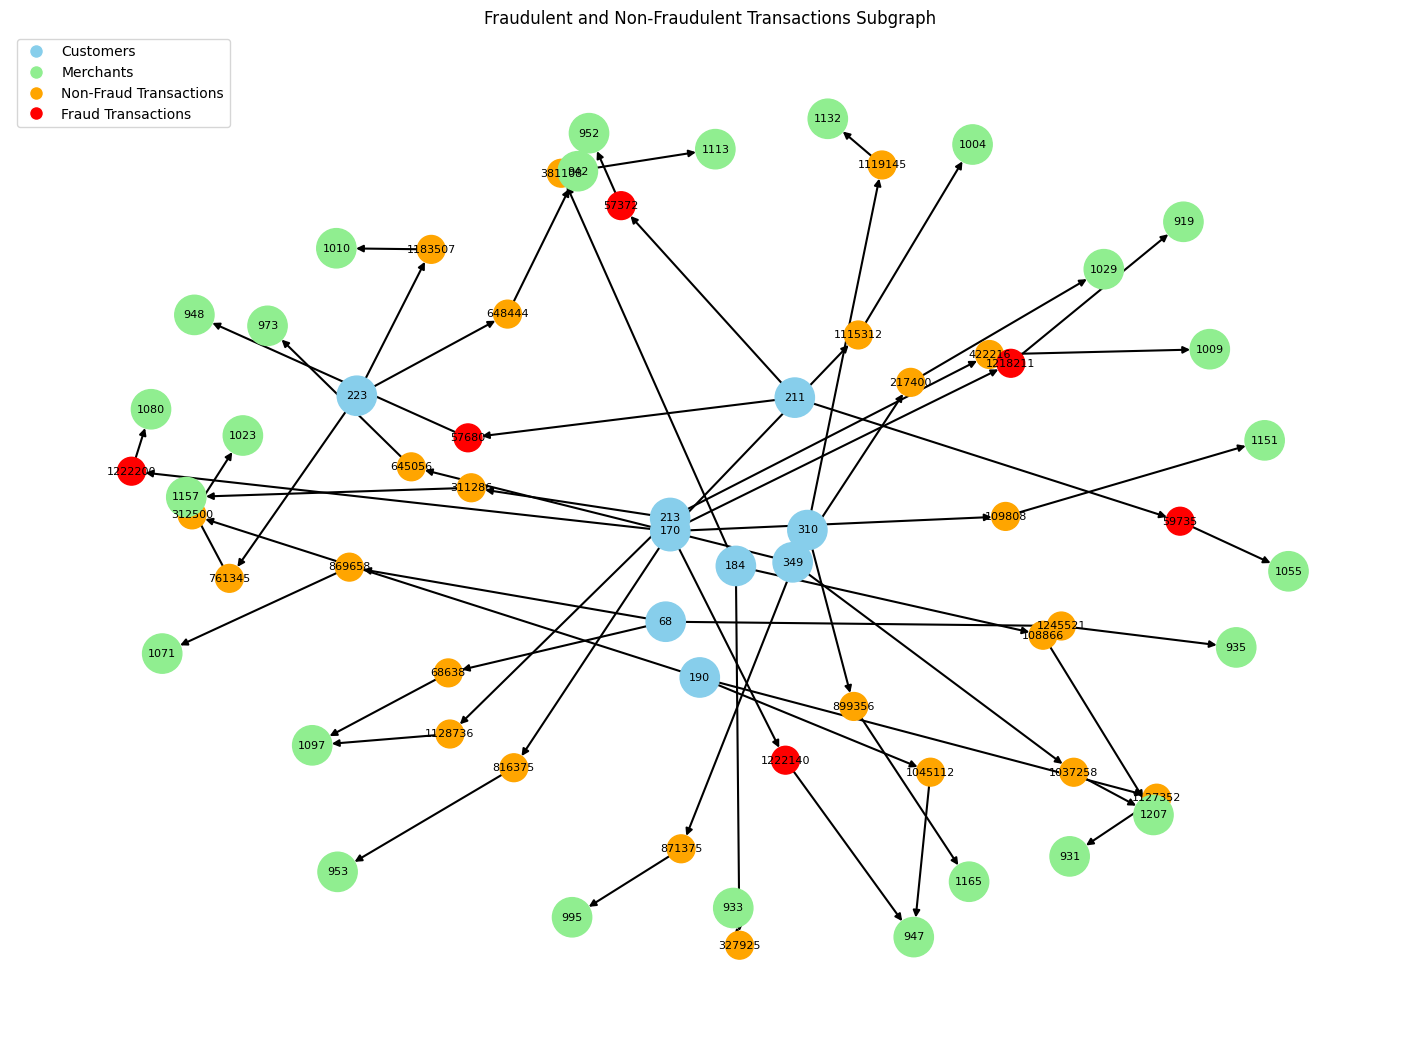

In [20]:
def visualize_fraud_subgraph(graph_data_path, transformed_data_path, num_transactions, fraud_ratio, transactions_per_customer):
    """
    Visualizes a subgraph containing customers, merchants, and transactions,
    ensuring ~fraud_ratio% fraudulent transactions and controlling transactions per customer.
    """
    try:
        # Load graph data
        data = torch.load(graph_data_path)
        df = pd.read_csv(transformed_data_path)
        
        # Identify fraud and non-fraud transactions
        fraud_transactions = df[df['is_fraud'] == 1]
        non_fraud_transactions = df[df['is_fraud'] == 0]
        
        # Determine the number of fraud transactions to select
        num_fraud = min(len(fraud_transactions), int(num_transactions * fraud_ratio))
        num_non_fraud = num_transactions - num_fraud
        
        # Select fraud transactions first
        selected_fraud = set()
        customers = fraud_transactions['customer_node'].unique().tolist()
        random.shuffle(customers)
        for customer in customers:
            customer_transactions = fraud_transactions[fraud_transactions['customer_node'] == customer]['transaction_node'].tolist()
            selected_fraud.update(random.sample(customer_transactions, min(transactions_per_customer, len(customer_transactions))))
            if len(selected_fraud) >= num_fraud:
                break
        selected_fraud = set(list(selected_fraud)[:num_fraud])  # Ensure exact count
        
        # Select non-fraud transactions
        selected_non_fraud = set()
        customers = non_fraud_transactions['customer_node'].unique().tolist()
        random.shuffle(customers)
        for customer in customers:
            customer_transactions = non_fraud_transactions[non_fraud_transactions['customer_node'] == customer]['transaction_node'].tolist()
            selected_non_fraud.update(random.sample(customer_transactions, min(transactions_per_customer, len(customer_transactions))))
            if len(selected_non_fraud) >= num_non_fraud:
                break
        selected_non_fraud = set(list(selected_non_fraud)[:num_non_fraud])  # Ensure exact count
        
        selected_transactions = selected_fraud | selected_non_fraud
        
        # Extract relevant edges
        edges = []
        customer_transacts_transaction = data[('customer', 'transacts', 'transaction')].edge_index.numpy()
        transaction_occurs_at_merchant = data[('transaction', 'occurs_at', 'merchant')].edge_index.numpy()
        
        for src, dst in zip(*customer_transacts_transaction):
            if df['transaction_node'].values[dst] in selected_transactions:
                edges.append((df['customer_node'].values[src], df['transaction_node'].values[dst]))
        
        for src, dst in zip(*transaction_occurs_at_merchant):
            if df['transaction_node'].values[src] in selected_transactions:
                edges.append((df['transaction_node'].values[src], df['merchant_node'].values[dst]))
        
        # Create the graph
        G = nx.DiGraph()
        G.add_edges_from(edges)
        
        # Node types and sizes
        node_colors = {}
        node_sizes = {}
        for node in G.nodes:
            if node in df['customer_node'].values:
                node_colors[node] = 'skyblue'  # Customers (Cards)
                node_sizes[node] = 800  # Large
            elif node in df['merchant_node'].values:
                node_colors[node] = 'lightgreen'  # Merchants
                node_sizes[node] = 800  # Large
            elif node in selected_transactions:
                node_colors[node] = 'red' if node in selected_fraud else 'orange'
                node_sizes[node] = 400  # Smaller
        
        # Draw graph
        pos = nx.spring_layout(G, k=0.3, iterations=50)
        plt.figure(figsize=(14, 10))
        nx.draw(
            G, pos, with_labels=True,
            node_color=[node_colors[n] for n in G.nodes],
            node_size=[node_sizes[n] for n in G.nodes],
            edge_color='black', width=1.5,
            font_size=8, arrows=True
        )
        
        # Legend
        legend_labels = {
            'skyblue': 'Customers',
            'lightgreen': 'Merchants',
            'orange': 'Non-Fraud Transactions',
            'red': 'Fraud Transactions'
        }
        legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                    markersize=10, markerfacecolor=color) for color, label in legend_labels.items()]
        plt.legend(handles=legend_patches, loc="upper left")
        plt.title("Fraudulent and Non-Fraudulent Transactions Subgraph")
        plt.show()
    
    except Exception as e:
        logging.error(f"Error visualizing graph: {e}")

# Example usage
graph_data_path = 'artifacts/graph_construction/graph_data.pt'
transformed_data_path = 'artifacts/graph_construction/node_mapped_data.csv'
visualize_fraud_subgraph(graph_data_path, transformed_data_path, num_transactions=30, fraud_ratio=0.2, transactions_per_customer=3)